In [2]:
import pandas as pd

# Load the data
data = pd.read_csv("raw_data_beforeencode.csv")

data.head()

,exposure,net_earned_premium,net_written_premium,claim_count,is_capped_incurred,capped_incurred,business_provider,cover,voluntary_xs,ncd,...,vehicle_make,d1_age,d1_residency_years,d1_is_uk_resident,transmission,region,gender,primary_car_colour,vehicle_purchase_year,licence_test_year
0,0.002740,0.00000,0.0000,0,0.0,0.0,CTMDefaultCampaign,COMP,250,0,...,Other,20,20,1,MANUAL,Other,Male,Blue,4,7
1,1.000000,238.33650,238.3365,0,0.0,0.0,CTMDefaultCampaign,COMP,0,7,...,FORD,25,25,1,MANUAL,South East,Female,Grey,6,11
2,0.420765,77.31347,183.7450,0,0.0,0.0,CTMDefaultCampaign,COMP,50,9,...,PEUGEOT,42,42,1,MANUAL,West Midlands,Female,Silver,7,29
3,1.000000,494.98150,246.5586,0,0.0,0.0,Other,COMP,100,0,...,Other,31,31,1,AUTOMATIC,North West,Female,White,4,4
4,1.000000,120.05060,120.0506,0,0.0,0.0,MSMDefaultCampaign,COMP,250,9,...,Other,61,61,1,MANUAL,South West,Male,Silver,10,49


In [3]:
# Perform one-hot encoding
categorical_cols = data.select_dtypes(include=['object']).columns
data_encoded = pd.get_dummies(data, columns=categorical_cols)

data_encoded.head()

,exposure,net_earned_premium,net_written_premium,claim_count,is_capped_incurred,capped_incurred,voluntary_xs,ncd,vehicle_value,vehicle_annual_mileage,...,region_Yorkshire,gender_Female,gender_Male,gender_Unknown,primary_car_colour_Black,primary_car_colour_Blue,primary_car_colour_Grey,primary_car_colour_Other,primary_car_colour_Silver,primary_car_colour_White
0,0.002740,0.00000,0.0000,0,0.0,0.0,250,0,1050,5000.0,...,0,0,1,0,0,1,0,0,0,0
1,1.000000,238.33650,238.3365,0,0.0,0.0,0,7,3000,4000.0,...,0,1,0,0,0,0,1,0,0,0
2,0.420765,77.31347,183.7450,0,0.0,0.0,50,9,2500,4000.0,...,0,1,0,0,0,0,0,0,1,0
3,1.000000,494.98150,246.5586,0,0.0,0.0,100,0,645,2000.0,...,0,1,0,0,0,0,0,0,0,1
4,1.000000,120.05060,120.0506,0,0.0,0.0,250,9,3145,8000.0,...,0,0,1,0,0,0,0,0,1,0


In [5]:
# Deal with Outliers
from scipy.stats import mstats

# Apply Winsorization to the 'capped_incurred' column
data_encoded['capped_incurred_winsorized'] = mstats.winsorize(data_encoded['capped_incurred'], limits=[0, 0.05])
data_winsorized = data_encoded.drop('capped_incurred', axis=1)

In [6]:
# Select features
from sklearn.ensemble import RandomForestRegressor

X = data_winsorized.drop(columns='capped_incurred_winsorized')
y = data_winsorized['capped_incurred_winsorized']

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

top_features = feature_importances.sort_values(ascending=False).head(10)
top_features

claim_count               0.177922
vehicle_value             0.177898
net_earned_premium        0.105792
net_written_premium       0.060561
vehicle_age               0.040928
vehicle_annual_mileage    0.036353
exposure                  0.034973
licence_test_year         0.032890
d1_residency_years        0.027911
d1_age                    0.027308
dtype: float64

In [7]:
# Classification
import warnings
warnings.filterwarnings("ignore")
data_winsorized_clf = data_winsorized.loc[data_winsorized.capped_incurred_winsorized >= 0, :]
data_winsorized_clf = data_winsorized_clf.loc[:, ('claim_count', 'vehicle_value',
                                                  'net_earned_premium', 'net_written_premium', 'vehicle_age',
                                                  'vehicle_annual_mileage', 'exposure', 'licence_test_year',
                                                  'd1_residency_years', 'd1_age', 'capped_incurred_winsorized')]
data_winsorized_clf.capped_incurred_winsorized[data_winsorized_clf.capped_incurred_winsorized > 0] = 1

In [8]:
from sklearn.preprocessing import LabelEncoder

X_data_clf = pd.get_dummies(data_winsorized_clf.iloc[:, :-1])
X_clf = X_data_clf.values
Y_data_clf = data_winsorized_clf.values[:, -1]
class_le = LabelEncoder()
Y_clf = class_le.fit_transform(Y_data_clf)

# Spliting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X_clf, Y_clf, test_size=0.2, random_state=42)

# Rabdom Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier(n_estimators=34, random_state=10)

clf.fit(X_train_clf, Y_train_clf)

y_predict_clf = clf.predict(X_test_clf)

print("Classification Report: ")
print(classification_report(Y_test_clf, y_predict_clf))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18429
           1       0.93      1.00      0.96      1207

    accuracy                           1.00     19636
   macro avg       0.97      1.00      0.98     19636
weighted avg       1.00      1.00      1.00     19636



In [ ]:
# After deciding whether or not the client is claiming, go to the claim amount prediction

In [8]:
categorical_cols = data.select_dtypes(include=['object']).columns
data_encoded = pd.get_dummies(data, columns=categorical_cols)

data_encoded.head()

,exposure,net_earned_premium,net_written_premium,claim_count,is_capped_incurred,capped_incurred,voluntary_xs,ncd,vehicle_value,vehicle_annual_mileage,...,region_Yorkshire,gender_Female,gender_Male,gender_Unknown,primary_car_colour_Black,primary_car_colour_Blue,primary_car_colour_Grey,primary_car_colour_Other,primary_car_colour_Silver,primary_car_colour_White
0,0.002740,0.00000,0.0000,0,0.0,0.0,250,0,1050,5000.0,...,0,0,1,0,0,1,0,0,0,0
1,1.000000,238.33650,238.3365,0,0.0,0.0,0,7,3000,4000.0,...,0,1,0,0,0,0,1,0,0,0
2,0.420765,77.31347,183.7450,0,0.0,0.0,50,9,2500,4000.0,...,0,1,0,0,0,0,0,0,1,0
3,1.000000,494.98150,246.5586,0,0.0,0.0,100,0,645,2000.0,...,0,1,0,0,0,0,0,0,0,1
4,1.000000,120.05060,120.0506,0,0.0,0.0,250,9,3145,8000.0,...,0,0,1,0,0,0,0,0,1,0


In [9]:
data_after_clf = data_encoded.loc[data_encoded.capped_incurred > 0, :]
data_after_clf_for_2predict = data_after_clf
data_after_clf_for_2predict.to_csv('data_after_clf_for_2predict.csv')

In [10]:
import pandas as pd
# Load the latest dataset
df = pd.read_csv('data_after_clf_for_2predict.csv')
df = df.drop(df.columns[0], axis=1)

df.head()

,exposure,net_earned_premium,net_written_premium,claim_count,is_capped_incurred,capped_incurred,voluntary_xs,ncd,vehicle_value,vehicle_annual_mileage,...,region_Yorkshire,gender_Female,gender_Male,gender_Unknown,primary_car_colour_Black,primary_car_colour_Blue,primary_car_colour_Grey,primary_car_colour_Other,primary_car_colour_Silver,primary_car_colour_White
0,0.838798,193.462006,230.6420,1,0.0,52.39,0,6,6895,6000.0,...,0,1,0,0,0,0,0,0,1,0
1,0.950820,711.545713,737.6796,1,0.0,130.10,250,4,2000,15000.0,...,0,1,0,0,1,0,0,0,0,0
2,1.000000,388.449700,388.4497,1,0.0,2029.95,250,9,10000,6500.0,...,1,1,0,0,1,0,0,0,0,0
3,1.000000,227.317900,224.2753,1,0.0,1355.39,100,9,15000,6000.0,...,0,1,0,0,1,0,0,0,0,0
4,0.890710,757.515121,1031.9178,1,0.0,1169.81,250,0,1900,10000.0,...,0,0,1,0,0,0,1,0,0,0


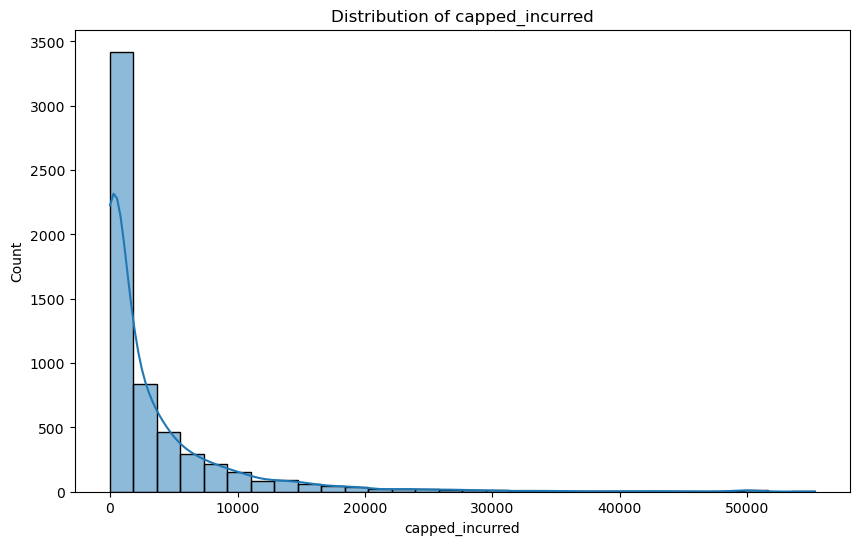

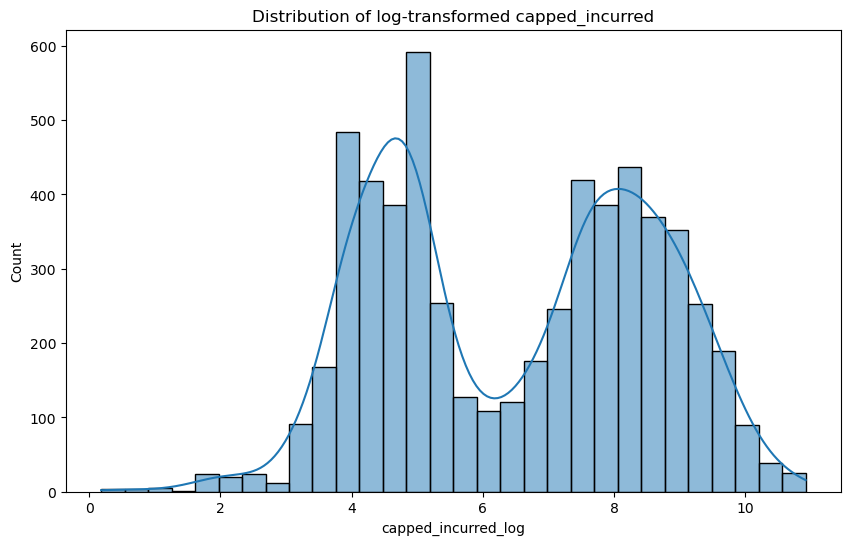

In [13]:
# Plot the distribution of 'capped_incurred'
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['capped_incurred'], bins=30, kde=True)
plt.title('Distribution of capped_incurred')
plt.show()

# Apply a log transformation to the 'capped_incurred' column remove OUTLIERS
import numpy as np
df['capped_incurred_log'] = np.log1p(df['capped_incurred'])

# Plot the distribution of the transformed data
plt.figure(figsize=(10, 6))
sns.histplot(df['capped_incurred_log'], bins=30, kde=True)
plt.title('Distribution of log-transformed capped_incurred')
plt.show()

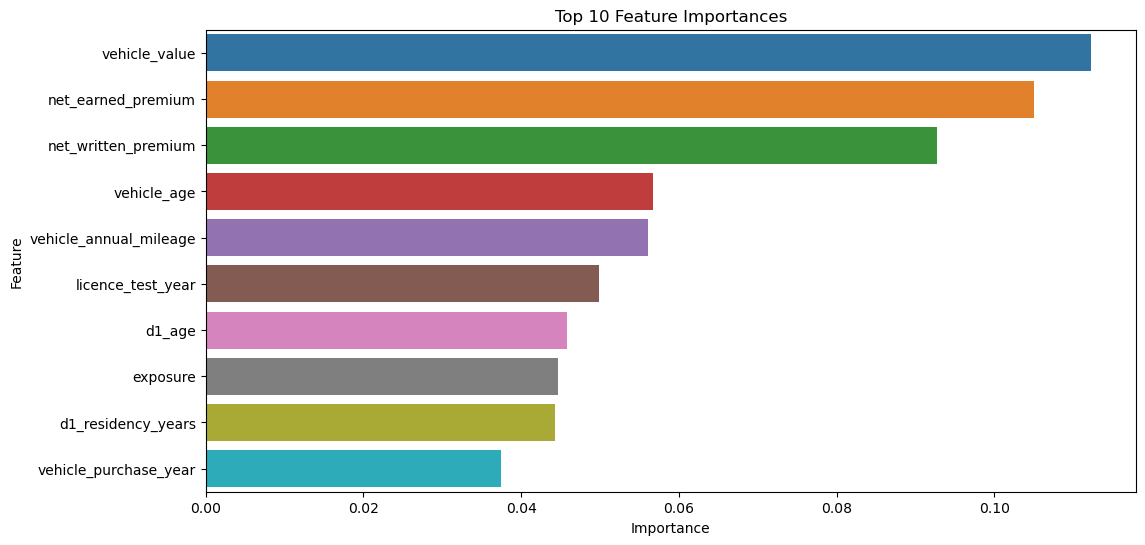

In [14]:
# Select features
from sklearn.ensemble import RandomForestRegressor

X = df.drop(['capped_incurred', 'capped_incurred_log'], axis=1)
y = df['capped_incurred_log']

# Train a Random Forest Regressor 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importances.sort_values('Importance', ascending=False, inplace=True)
feature_importances.head(10)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [15]:
# Predict Claim Amount
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Select the top 10 features
top_features = feature_importances['Feature'][:10]

X_top = df[top_features]
y = df['capped_incurred_log']

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train a Random Forest model on the training set
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_predict_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_predict_rf)

mse_rf

4.141910400389904

In [ ]:
####### Question #########
# Declaring Residency Year - 5 Years
# Declaring License Year - 15 Years

